### Info:
- c1 is the gate voltage, c2- output voltage and c3- current.

### Todo:
- [x] Solve f such that f(c1, c3) = c2
- [x] Differentiate between expt, ideal, model
- [ ] Solve f such that f(c1, c2) = c3
- [ ] Solve f such that f(c1) = c2, c3  (multiple ouputs)
- [ ] Differentiate between panasonic, transform, GaNsystems (use scalar parameters)
- [ ] Test meta-learning? - train on data from 2 devices, test on third?
    - Can also perform one-shot learning with ideal/model data to finally predict the expt data

In [1]:
import os
import glob
from datetime import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import keras
from keras.models import Sequential
from keras.layers import Dense, LSTM, GRU
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.layers import Dropout
from keras import backend as K

np.set_printoptions(suppress=True)

/home/saurabh/anaconda2/envs/pandagrader/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

## Reading all data

In [22]:
base_dir = '../../../Nikki/data'
data_dirs = [f'{base_dir}/data_02_03_18', f'{base_dir}/data_01_12_18']
fig_dir = './plots'

def read_data(data_dir):
    def is_it_c1_c2_or_c3(filename):
        return filename.split(' ')[-1].split('.')[0]
    
    dir_structures = list(os.walk(f'{data_dir}'))
    data_dicts = []
    for dirpath, dirnames, filenames in dir_structures[1:]:
        data_dict = {}
        data_dict['dir'] = dirpath
        for filename in filenames:
            data = is_it_c1_c2_or_c3(filename)
            data_dict[f'{data}_file'] = f'{filename}'
        device_name, data_type = dirpath.split('/')[-1].strip().split()
        data_dict['device_name'] = device_name.lower()
        data_dict['graph_type'] = data_type.lower()
        data_dict['date'] = '-'.join(data_dir.split('_')[-3:])
        data_dicts.append(data_dict)
    return data_dicts

df = pd.DataFrame(read_data(data_dirs[0]) + read_data(data_dirs[1]))

In [23]:
def read_datafile(filename):
    time, cx = zip(*[
        list(map(float, line.strip().split('\t'))) 
        for line in open(filename, 'r')
    ])
    return [t * 1e09 for t in time], list(cx)

df['c1'] = [read_datafile(f'{row.dir}/{row.c1_file}')[1] for _, row in df.iterrows()]
df['c2'] = [read_datafile(f'{row.dir}/{row.c2_file}')[1] for _, row in df.iterrows()]
df['c3'] = [read_datafile(f'{row.dir}/{row.c3_file}')[1] for _, row in df.iterrows()]
df['len'] = [len(row.c1) for _, row in df.iterrows()]
del df['dir']
df

,c1_file,c2_file,c3_file,date,device_name,graph_type,c1,c2,c3,len
0,panasonic ideal gate voltage c1.txt,panasonic ideal switching voltage c2.txt,panasonic ideal current c3.txt,02-03-18,panasonic,ideal,"[4.12497, 4.12497, 4.12497, 4.12497, 4.12497, ...","[4.12497, 4.12497, 4.12497, 4.12497, 4.12497, ...","[20.5625, 20.5625, 20.5625, 20.5625, 20.5625, ...",1002
1,transphorm ideal gate voltage c1.txt,transphorm ideal voltage c2.txt,Transphorm ideal current c3.txt,02-03-18,transphorm,ideal,"[8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, ...","[3.12497, 3.12497, 3.12497, 3.12497, -3.05e-05...","[20.5625, 20.5625, 20.875, 20.875, 21.1875, 20...",1002
2,GaNsystems ideal gate voltage c1.txt,GaNSystems ideal switching voltage c2.txt,GaNsystems ideal current c3.txt,02-03-18,gansystems,ideal,"[6.00123, 6.00123, 6.00123, 6.00123, 6.00123, ...","[3.12497, 3.12497, 3.12497, 3.12497, 3.12497, ...","[15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15....",1002
3,panasonic gate voltage c1.txt,panasonic model voltage c2.txt,panasonic model current c3.txt,02-03-18,panasonic,model,"[3.4375, 3.28125, 3.4375, 3.28125, 3.4375, 3.4...","[4.12497, 3.59375, 3.59375, 3.4375, 3.4375, 3....","[20.25, 20.5625, 20.5625, 20.5625, 20.875, 20....",1002
4,transphorm expt gate voltage c1.txt,transphorm expt voltage c2.txt,Transphorm expt current c3.txt,02-03-18,transphorm,expt,"[7.4375, 7.125, 7.59375, 7.4375, 7.28125, 7.28...","[7.5, 4.375, 7.5, 4.375, 4.375, 4.375, 10.625,...","[20.5625, 20.5625, 20.875, 20.875, 21.1875, 20...",1002
5,GaNsystems model gate voltage c1.txt,GaNSystems model switching voltage c2.txt,GaNsystems model current c3.txt,02-03-18,gansystems,model,"[5.90123, 5.90123, 5.90123, 5.90123, 5.90123, ...","[6.24997, 3.12497, -3.05e-05, -3.05e-05, 3.124...","[15.25, 15.25, 15.25, 15.25, 15.25, 15.25, 15....",1002
6,GaNsystems expt gate voltage c1.txt,GaNSystems expt switching voltage c2.txt,GaNsystems expt current c3.txt,02-03-18,gansystems,expt,"[6.41563, 6.25625, 5.9375, 6.25625, 6.25625, 6...","[6.24997, 3.12497, -3.05e-05, -3.05e-05, 3.124...","[15.25, 15.5625, 15.5625, 15.875, 15.5625, 15....",1002
7,transphorm model gate voltage c1.txt,transphorm model voltage c2.txt,Transphorm model current c3.txt,02-03-18,transphorm,model,"[8.4375, 8.125, 8.59375, 8.4375, 8.28125, 8.28...","[3.12497, 3.12497, 3.12497, 3.12497, -3.05e-05...","[20.25, 20.875, 20.5625, 20.875, 20.25, 20.875...",1002
8,panasonic expt gate voltage c1.txt,panasonic expt voltage c2.txt,panasonic expt current c3.txt,02-03-18,panasonic,expt,"[3.4375, 3.125, 3.59375, 3.4375, 3.28125, 3.28...","[4.375, 1.25, 1.25, 7.5, 1.25, 1.25, -1.875, 4...","[20.5625, 20.5625, 20.875, 20.875, 21.1875, 20...",1002
9,panasonic ideal gate voltage c1.txt,panasonic ideal switching voltage c2.txt,panasonic ideal current c3.txt,01-12-18,panasonic,ideal,"[3.1375, 3.1375, 3.1375, 3.1375, 3.1375, 3.137...","[4.12497, 4.12497, 4.12497, 4.12497, 4.12497, ...","[20.5625, 20.5625, 20.5625, 20.5625, 20.5625, ...",1002


## Ploting all data

In [24]:
def plot_data(c1, c2, c3, c1_pred=None, c2_pred=None, c3_pred=None, title=None, save=False):
    assert len(c1) == len(c2) == len(c3)
    plts = {}
    fig, ax1 = plt.subplots(1,1, figsize=(16, 8))
    if title:
        ax1.set_title(title)
    x = range(len(c1))

    plts['c2'] = ax1.plot(x, c2, c='b', label='c2/output voltage')
    if c2_pred is not None:
        plts['c2_pred'] = ax1.plot(x, c2_pred, c='k', label='c2 pred/output voltage')
    ax1.set_ylabel('Output voltage (Vds)', color='b')
    ax1.tick_params('y', colors='b')
    ax1.set_xlabel('time steps')

    ax2 = ax1.twinx()
    plts['c1'] = ax2.plot(x, c1, c='g', label='c1/gate voltage')
    plts['c3'] = ax2.plot(x, c3, c='r', label='c3/current')
    if c1_pred is not None:
        plts['c1_pred'] = ax2.plot(x, c1_pred, c='k', label='c1 pred/gate voltage')
    if c3_pred is not None:
        plts['c3_pred'] = ax2.plot(x, c3_pred, c='k', label='c3 pred/current')        
        
    ax2.set_ylabel('Gate voltage (Vgs) / Current (Ids)', color='r')
    ax2.tick_params('y', colors='r')

    plts_list = [plts[k][0] for k in sorted(list(plts.keys()))]
    labels = [l.get_label() for l in plts_list]
    ax1.legend(plts_list, labels, loc='upper right')
    if save and title:
        plt.savefig(f'{fig_dir}/{title}.png')

In [25]:
df.date.unique()

array(['02-03-18', '01-12-18'], dtype=object)

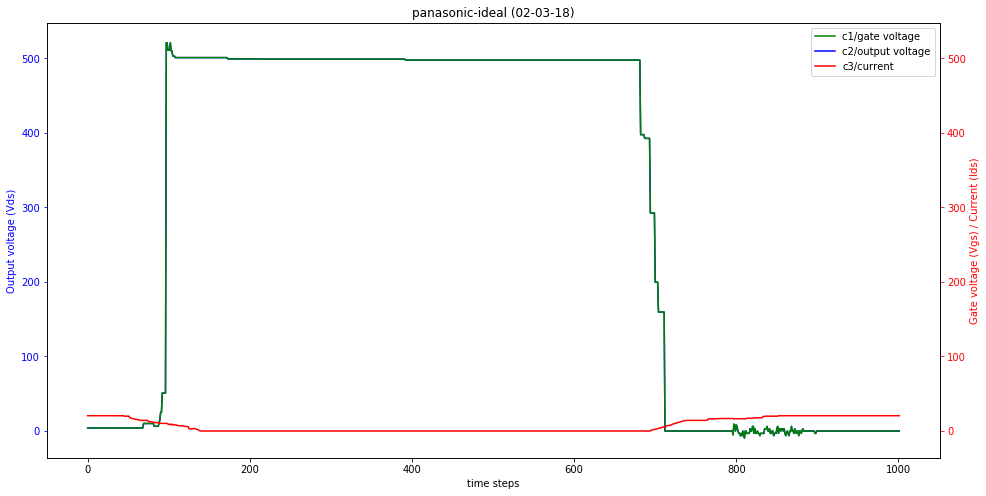

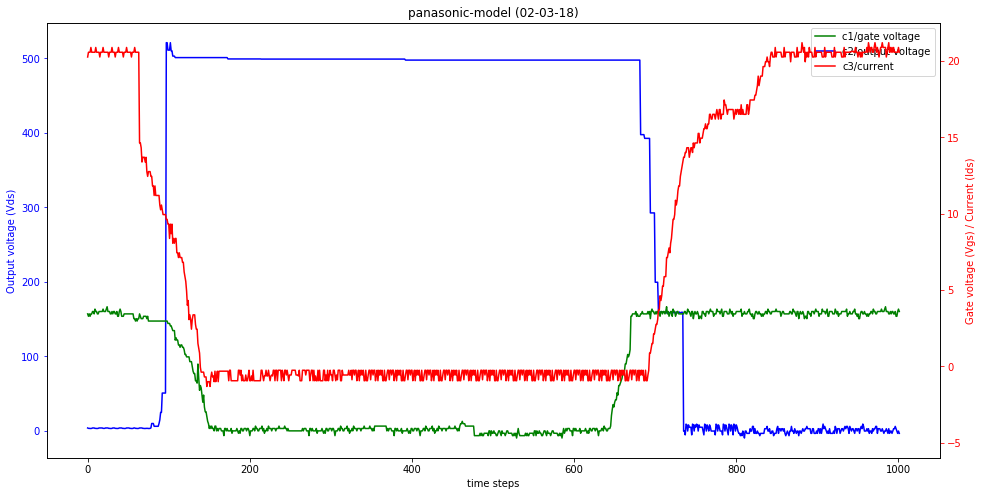

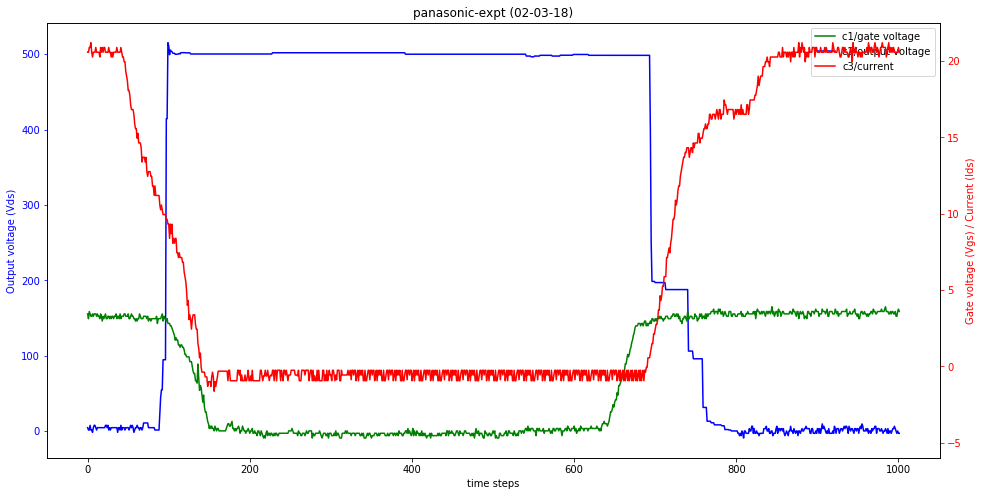

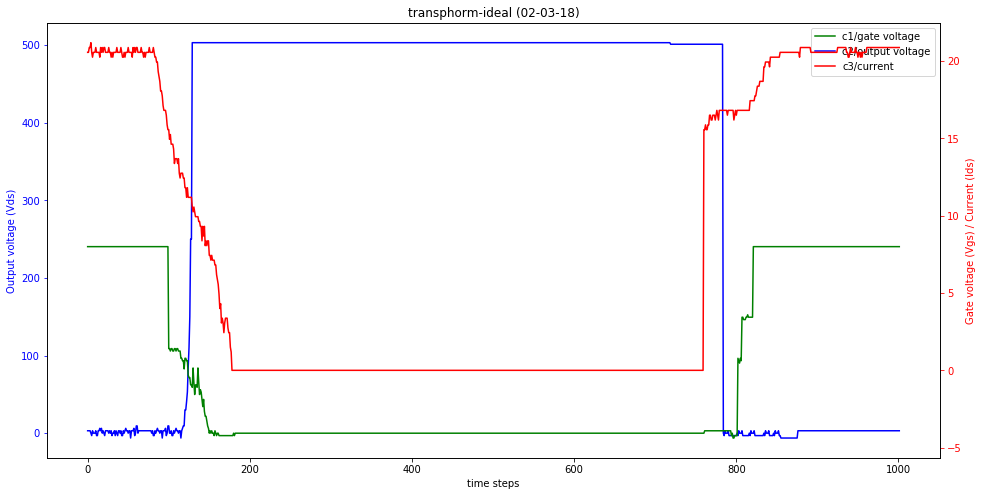

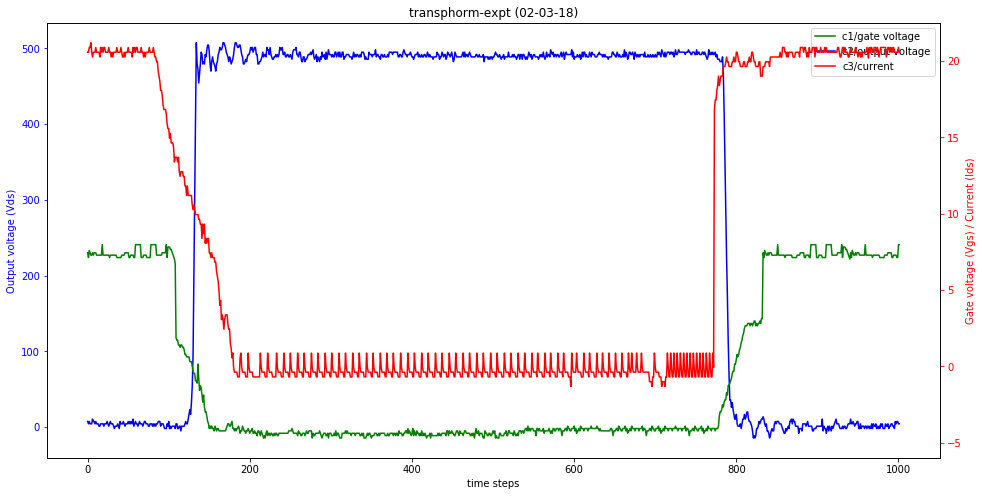

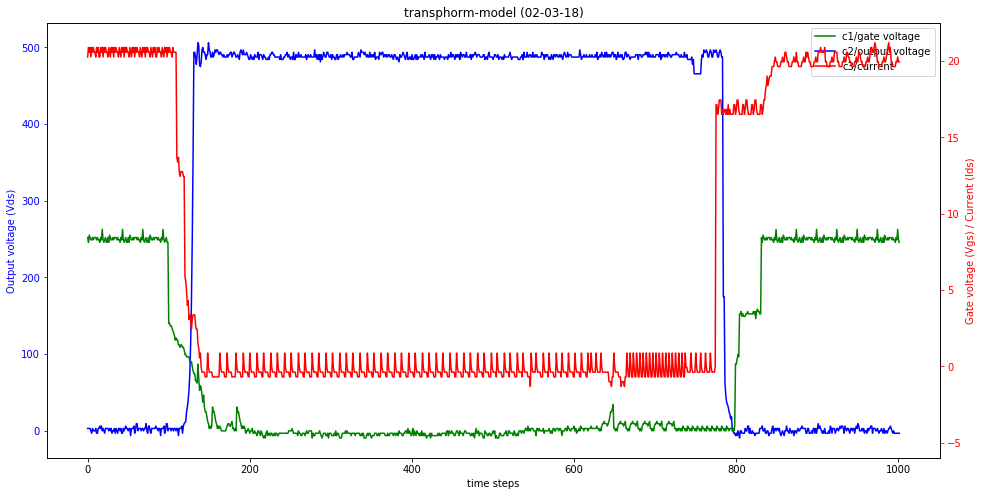

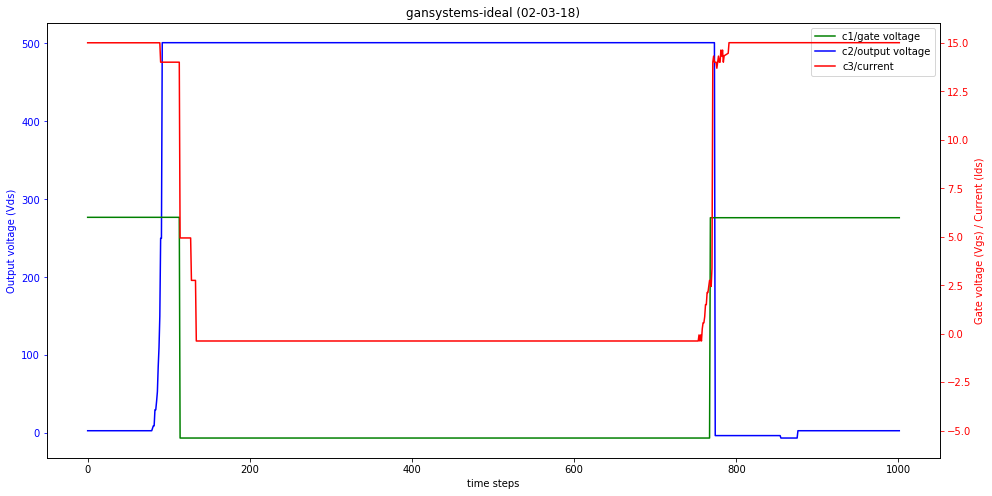

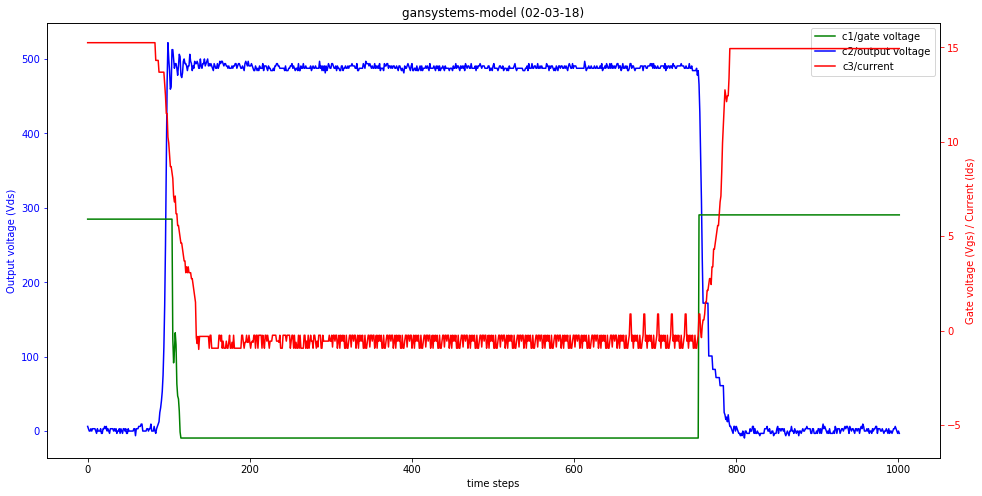

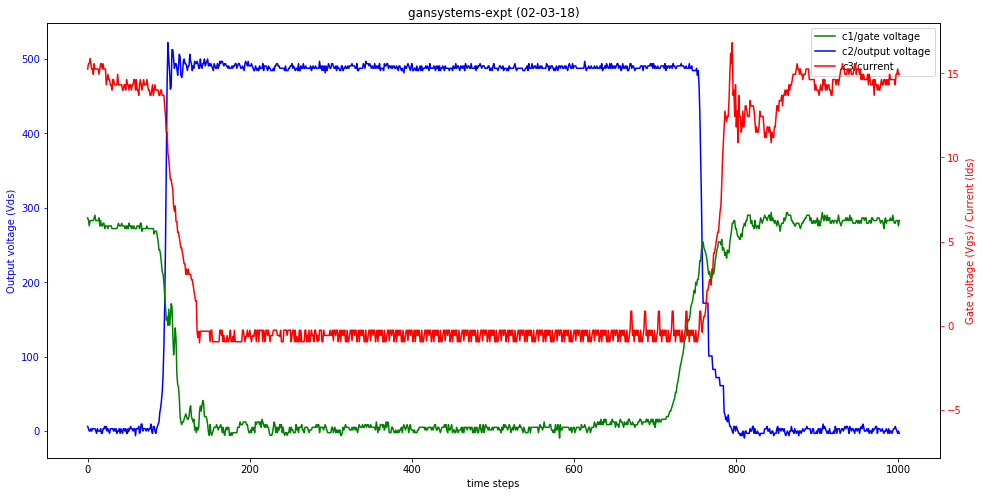

In [26]:
## So let's understand what's the difference between expt, model, ideal
def plot_all_graphs_on(date, save):
    for device_name in df.device_name.unique():
        plot_df = df[(df.device_name == device_name) & (df.date == date)]
        for _, row in plot_df.iterrows():
            plot_data(row.c1, row.c2, row.c3, title=f'{row.device_name}-{row.graph_type} ({row.date})', save=save)
            
plot_all_graphs_on(date='02-03-18', save=False)

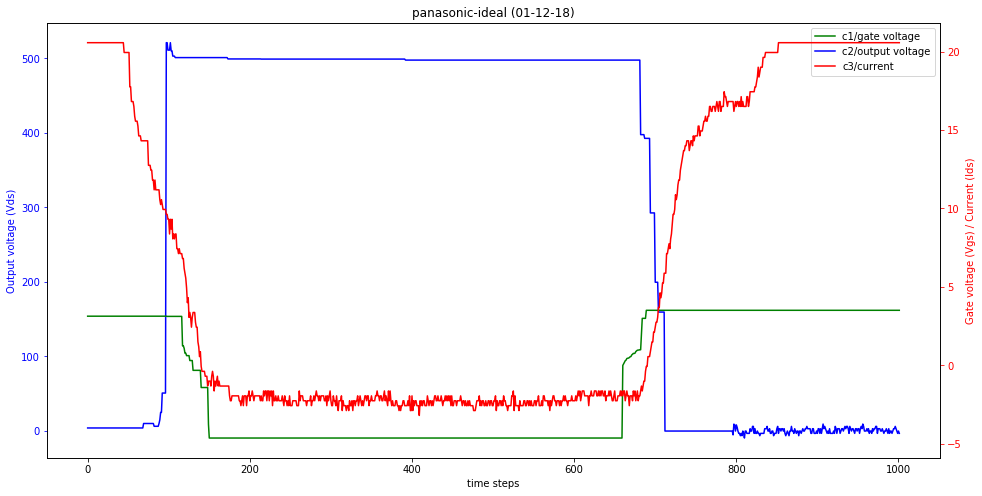

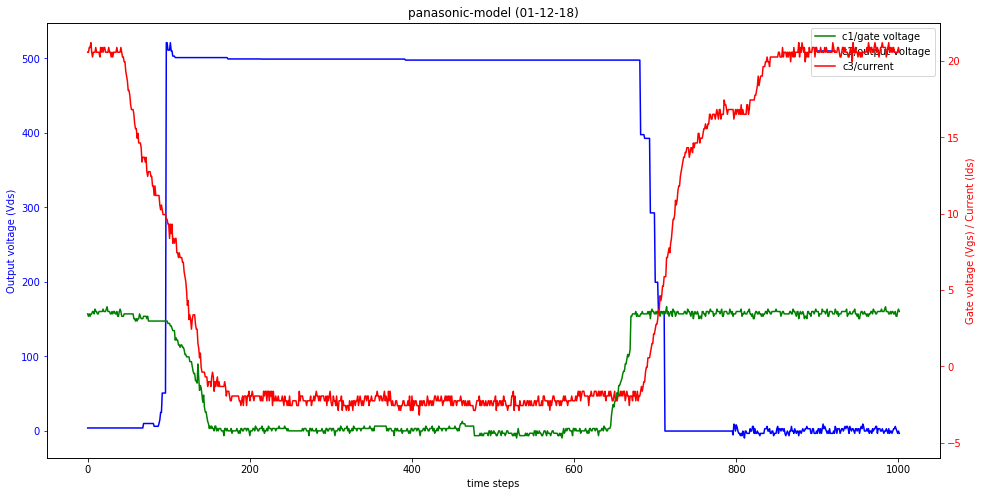

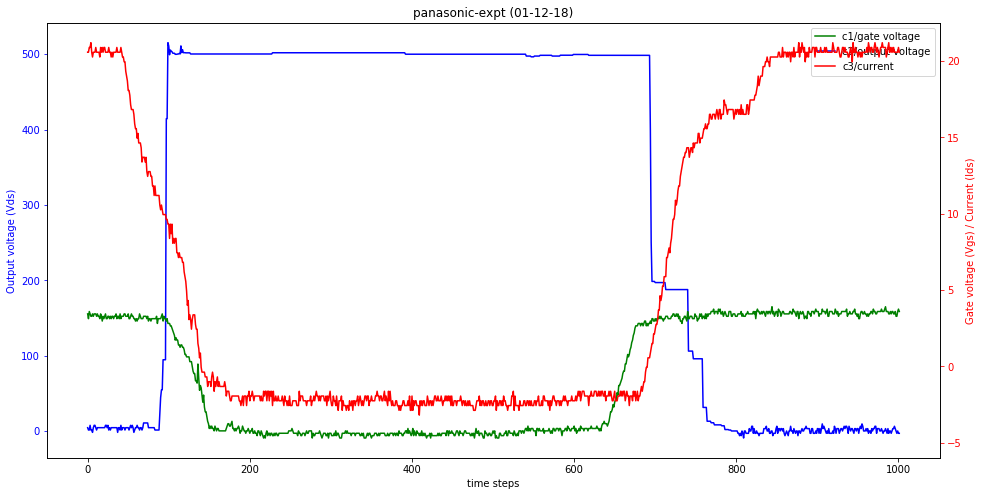

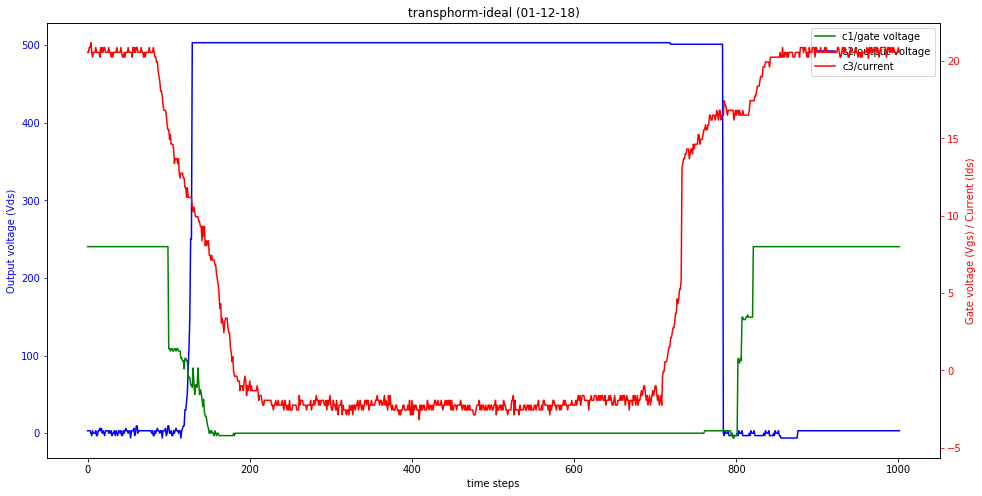

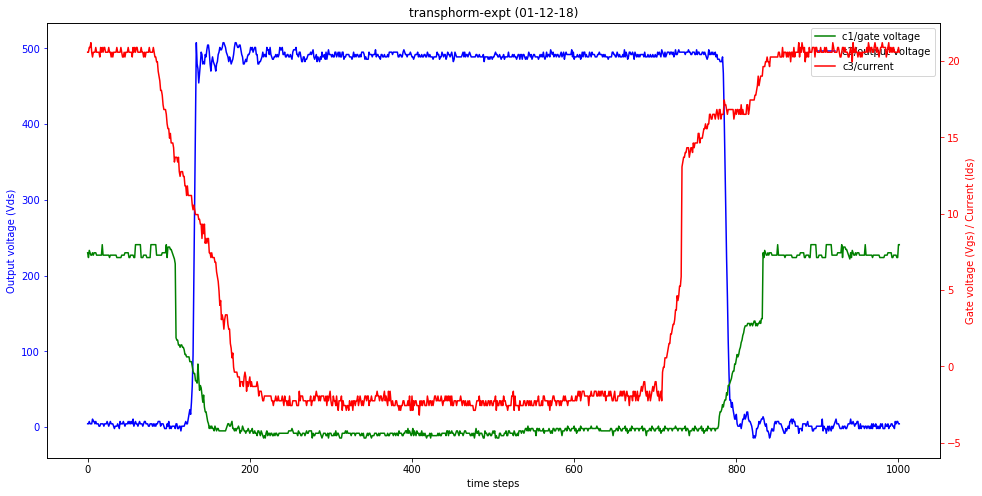

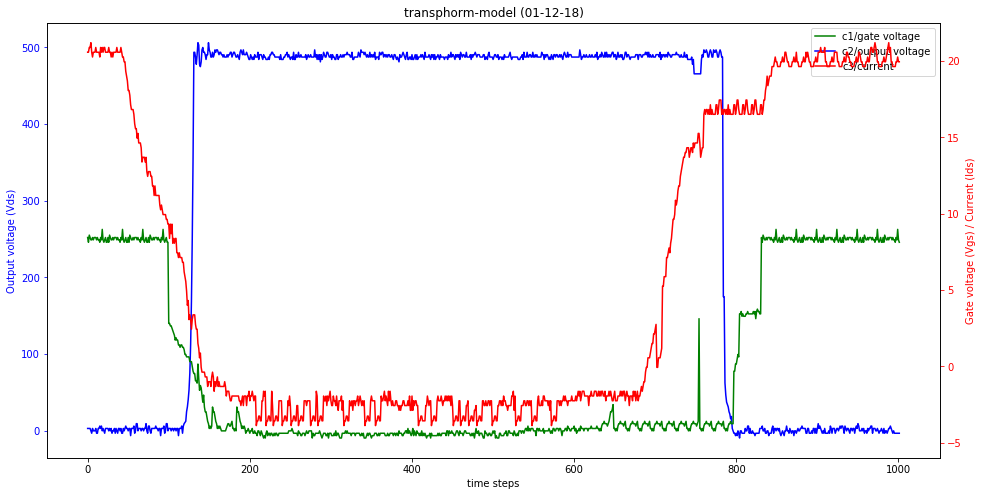

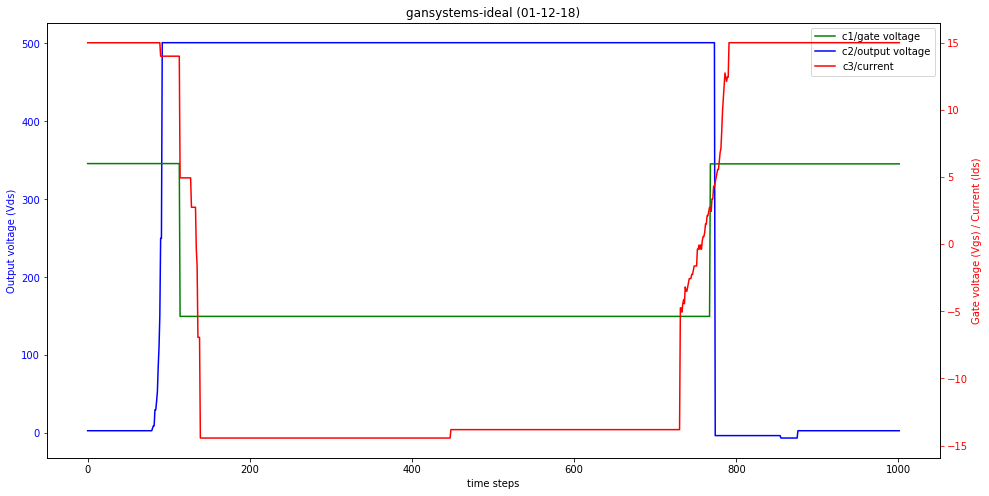

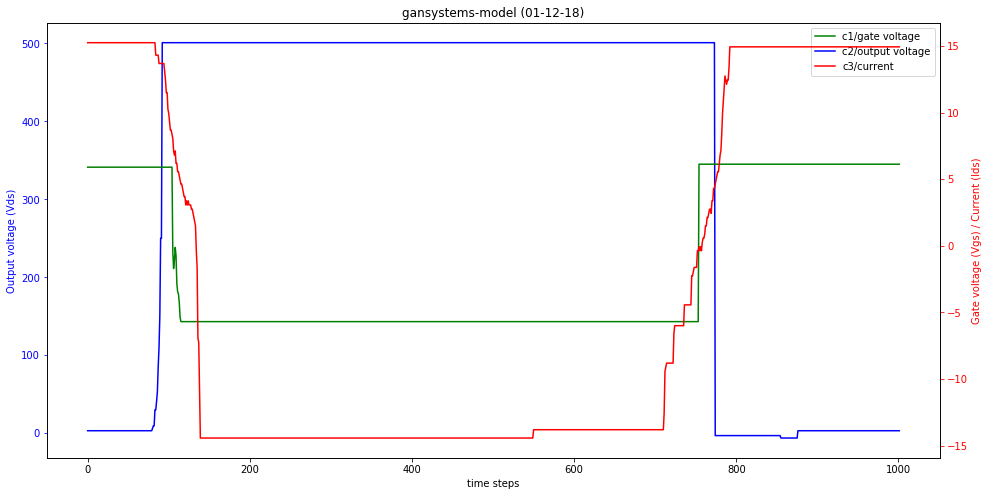

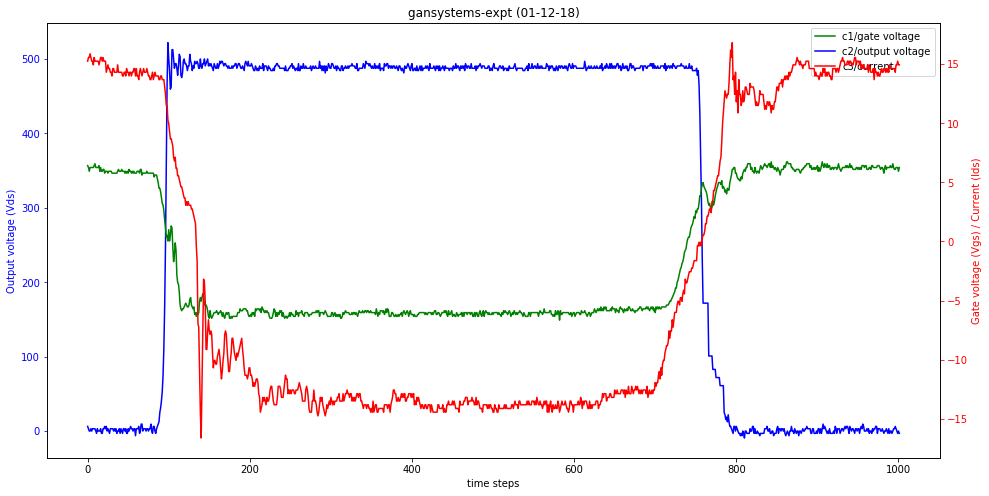

In [27]:
plot_all_graphs_on(date='01-12-18', save=False)

### From observation, there seems to be a problem with Panasonic-ideal (02-03-18) - so remove it

In [28]:
drop_index = df[(df.device_name == 'panasonic') & (df.date == '02-03-18') & (df.graph_type == 'ideal')].index
df.drop(df.index[drop_index], inplace=True)
df

,c1_file,c2_file,c3_file,date,device_name,graph_type,c1,c2,c3,len
1,transphorm ideal gate voltage c1.txt,transphorm ideal voltage c2.txt,Transphorm ideal current c3.txt,02-03-18,transphorm,ideal,"[8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, ...","[3.12497, 3.12497, 3.12497, 3.12497, -3.05e-05...","[20.5625, 20.5625, 20.875, 20.875, 21.1875, 20...",1002
2,GaNsystems ideal gate voltage c1.txt,GaNSystems ideal switching voltage c2.txt,GaNsystems ideal current c3.txt,02-03-18,gansystems,ideal,"[6.00123, 6.00123, 6.00123, 6.00123, 6.00123, ...","[3.12497, 3.12497, 3.12497, 3.12497, 3.12497, ...","[15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15....",1002
3,panasonic gate voltage c1.txt,panasonic model voltage c2.txt,panasonic model current c3.txt,02-03-18,panasonic,model,"[3.4375, 3.28125, 3.4375, 3.28125, 3.4375, 3.4...","[4.12497, 3.59375, 3.59375, 3.4375, 3.4375, 3....","[20.25, 20.5625, 20.5625, 20.5625, 20.875, 20....",1002
4,transphorm expt gate voltage c1.txt,transphorm expt voltage c2.txt,Transphorm expt current c3.txt,02-03-18,transphorm,expt,"[7.4375, 7.125, 7.59375, 7.4375, 7.28125, 7.28...","[7.5, 4.375, 7.5, 4.375, 4.375, 4.375, 10.625,...","[20.5625, 20.5625, 20.875, 20.875, 21.1875, 20...",1002
5,GaNsystems model gate voltage c1.txt,GaNSystems model switching voltage c2.txt,GaNsystems model current c3.txt,02-03-18,gansystems,model,"[5.90123, 5.90123, 5.90123, 5.90123, 5.90123, ...","[6.24997, 3.12497, -3.05e-05, -3.05e-05, 3.124...","[15.25, 15.25, 15.25, 15.25, 15.25, 15.25, 15....",1002
6,GaNsystems expt gate voltage c1.txt,GaNSystems expt switching voltage c2.txt,GaNsystems expt current c3.txt,02-03-18,gansystems,expt,"[6.41563, 6.25625, 5.9375, 6.25625, 6.25625, 6...","[6.24997, 3.12497, -3.05e-05, -3.05e-05, 3.124...","[15.25, 15.5625, 15.5625, 15.875, 15.5625, 15....",1002
7,transphorm model gate voltage c1.txt,transphorm model voltage c2.txt,Transphorm model current c3.txt,02-03-18,transphorm,model,"[8.4375, 8.125, 8.59375, 8.4375, 8.28125, 8.28...","[3.12497, 3.12497, 3.12497, 3.12497, -3.05e-05...","[20.25, 20.875, 20.5625, 20.875, 20.25, 20.875...",1002
8,panasonic expt gate voltage c1.txt,panasonic expt voltage c2.txt,panasonic expt current c3.txt,02-03-18,panasonic,expt,"[3.4375, 3.125, 3.59375, 3.4375, 3.28125, 3.28...","[4.375, 1.25, 1.25, 7.5, 1.25, 1.25, -1.875, 4...","[20.5625, 20.5625, 20.875, 20.875, 21.1875, 20...",1002
9,panasonic ideal gate voltage c1.txt,panasonic ideal switching voltage c2.txt,panasonic ideal current c3.txt,01-12-18,panasonic,ideal,"[3.1375, 3.1375, 3.1375, 3.1375, 3.1375, 3.137...","[4.12497, 4.12497, 4.12497, 4.12497, 4.12497, ...","[20.5625, 20.5625, 20.5625, 20.5625, 20.5625, ...",1002
10,transphorm ideal gate voltage c1.txt,transphorm ideal voltage c2.txt,Transphorm ideal current c3.txt,01-12-18,transphorm,ideal,"[8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, ...","[3.12497, 3.12497, 3.12497, 3.12497, -3.05e-05...","[20.5625, 20.5625, 20.875, 20.875, 21.1875, 20...",1002


## Splitting data for training

 - Data info: 17 plots in total (**6 `expts`**, 6 `model`, 5 `ideal`)
 - We should `test` the model **only** on `expt` data as that is the final objective.
 - 2 logical ways to generate the `test` data:
     - **Approach [1]** - have 1 plot from each of the devices - implying the data for that device has been exposed to the model during training
     - **Approach [2]** - have 2 plots from a specific device - implying the data for that device has **not** been exposed to the model during training (this is a case of meta-learning)
 - Due to the limited data (especially `expt`), we decide not to have a `validation` data split

In [29]:
## Taking Approach 1 for test data 
# - have 1 plot from each of the devices 
# - implying the data for that device has been exposed to the model during training

test_date = '02-03-18'
test_df = df[(df.graph_type == 'expt') & (df.date == test_date)]
test_df

,c1_file,c2_file,c3_file,date,device_name,graph_type,c1,c2,c3,len
4,transphorm expt gate voltage c1.txt,transphorm expt voltage c2.txt,Transphorm expt current c3.txt,02-03-18,transphorm,expt,"[7.4375, 7.125, 7.59375, 7.4375, 7.28125, 7.28...","[7.5, 4.375, 7.5, 4.375, 4.375, 4.375, 10.625,...","[20.5625, 20.5625, 20.875, 20.875, 21.1875, 20...",1002
6,GaNsystems expt gate voltage c1.txt,GaNSystems expt switching voltage c2.txt,GaNsystems expt current c3.txt,02-03-18,gansystems,expt,"[6.41563, 6.25625, 5.9375, 6.25625, 6.25625, 6...","[6.24997, 3.12497, -3.05e-05, -3.05e-05, 3.124...","[15.25, 15.5625, 15.5625, 15.875, 15.5625, 15....",1002
8,panasonic expt gate voltage c1.txt,panasonic expt voltage c2.txt,panasonic expt current c3.txt,02-03-18,panasonic,expt,"[3.4375, 3.125, 3.59375, 3.4375, 3.28125, 3.28...","[4.375, 1.25, 1.25, 7.5, 1.25, 1.25, -1.875, 4...","[20.5625, 20.5625, 20.875, 20.875, 21.1875, 20...",1002


In [30]:
train_df = df.copy()
train_df.drop(test_df.index, inplace=True)
train_df

,c1_file,c2_file,c3_file,date,device_name,graph_type,c1,c2,c3,len
1,transphorm ideal gate voltage c1.txt,transphorm ideal voltage c2.txt,Transphorm ideal current c3.txt,02-03-18,transphorm,ideal,"[8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, ...","[3.12497, 3.12497, 3.12497, 3.12497, -3.05e-05...","[20.5625, 20.5625, 20.875, 20.875, 21.1875, 20...",1002
2,GaNsystems ideal gate voltage c1.txt,GaNSystems ideal switching voltage c2.txt,GaNsystems ideal current c3.txt,02-03-18,gansystems,ideal,"[6.00123, 6.00123, 6.00123, 6.00123, 6.00123, ...","[3.12497, 3.12497, 3.12497, 3.12497, 3.12497, ...","[15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15....",1002
3,panasonic gate voltage c1.txt,panasonic model voltage c2.txt,panasonic model current c3.txt,02-03-18,panasonic,model,"[3.4375, 3.28125, 3.4375, 3.28125, 3.4375, 3.4...","[4.12497, 3.59375, 3.59375, 3.4375, 3.4375, 3....","[20.25, 20.5625, 20.5625, 20.5625, 20.875, 20....",1002
5,GaNsystems model gate voltage c1.txt,GaNSystems model switching voltage c2.txt,GaNsystems model current c3.txt,02-03-18,gansystems,model,"[5.90123, 5.90123, 5.90123, 5.90123, 5.90123, ...","[6.24997, 3.12497, -3.05e-05, -3.05e-05, 3.124...","[15.25, 15.25, 15.25, 15.25, 15.25, 15.25, 15....",1002
7,transphorm model gate voltage c1.txt,transphorm model voltage c2.txt,Transphorm model current c3.txt,02-03-18,transphorm,model,"[8.4375, 8.125, 8.59375, 8.4375, 8.28125, 8.28...","[3.12497, 3.12497, 3.12497, 3.12497, -3.05e-05...","[20.25, 20.875, 20.5625, 20.875, 20.25, 20.875...",1002
9,panasonic ideal gate voltage c1.txt,panasonic ideal switching voltage c2.txt,panasonic ideal current c3.txt,01-12-18,panasonic,ideal,"[3.1375, 3.1375, 3.1375, 3.1375, 3.1375, 3.137...","[4.12497, 4.12497, 4.12497, 4.12497, 4.12497, ...","[20.5625, 20.5625, 20.5625, 20.5625, 20.5625, ...",1002
10,transphorm ideal gate voltage c1.txt,transphorm ideal voltage c2.txt,Transphorm ideal current c3.txt,01-12-18,transphorm,ideal,"[8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, ...","[3.12497, 3.12497, 3.12497, 3.12497, -3.05e-05...","[20.5625, 20.5625, 20.875, 20.875, 21.1875, 20...",1002
11,GaNsystems ideal gate voltage c1.txt,GaNSystems ideal switching voltage c2.txt,GaNsystems ideal current c3.txt,01-12-18,gansystems,ideal,"[6.00123, 6.00123, 6.00123, 6.00123, 6.00123, ...","[3.12497, 3.12497, 3.12497, 3.12497, 3.12497, ...","[15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15....",1002
12,panasonic gate voltage c1.txt,panasonic model voltage c2.txt,panasonic model current c3.txt,01-12-18,panasonic,model,"[3.4375, 3.28125, 3.4375, 3.28125, 3.4375, 3.4...","[4.12497, 4.12497, 4.12497, 4.12497, 4.12497, ...","[20.5625, 20.5625, 20.875, 20.875, 21.1875, 20...",1002
13,transphorm expt gate voltage c1.txt,transphorm expt voltage c2.txt,Transphorm expt current c3.txt,01-12-18,transphorm,expt,"[7.4375, 7.125, 7.59375, 7.4375, 7.28125, 7.28...","[4.5, 4.375, 7.5, 4.375, 4.375, 4.375, 10.625,...","[20.5625, 20.5625, 20.875, 20.875, 21.1875, 20...",1002


# Experiments

## Model 1: f(c1, c3) = c2

In [31]:
def generate_model_data(df, inputs, output):
    x = np.stack([np.stack([row[inputs[0]], row[inputs[1]]], axis=-1) for _, row in df.iterrows()], axis=0)
    y = np.expand_dims(np.stack(df[output].tolist(), axis=0), axis=-1)
    return x, y

x_train, y_train = generate_model_data(train_df, inputs=['c1', 'c3'], output='c2')
x_test, y_test = generate_model_data(test_df, inputs=['c1', 'c3'], output='c2')
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((14, 1002, 2), (14, 1002, 1), (3, 1002, 2), (3, 1002, 1))

In [32]:
# If all lengths are not same - use keras.preprocessing.sequence.pad_sequences() to pad to largest size as:
# x_train = np.array(sequence.pad_sequences(x_train, maxlen=max_time_sequence, dtype=np.float64))
assert len(df.len.unique()) == 1

In [33]:
def standardize_features(x, mean=None, std=None):
    if mean is None:
        mean, std = np.mean(x, axis=(0, 1)), np.std(x, axis=(0, 1))
    return (x - mean) / std, mean, std

x_train, x_mean, x_std = standardize_features(x_train)
x_test, _, _ = standardize_features(x_test, x_mean, x_std)

y_train, y_mean, y_std = standardize_features(y_train)
y_test, _, _ = standardize_features(y_test, y_mean, y_std)

In [34]:
max_time_sequence = x_train.shape[1]

### Model def

In [35]:
# input : (batch_size, max_time_sequence, input_dim)
model = Sequential()
nodes = [32, 32]
# model.add(GRU(64, return_sequences=True, input_shape=(max_time_sequence, 2)))
# model.add(LSTM(nodes[0], return_sequences=True, dropout=0.2, recurrent_dropout=0.2, input_shape=(max_time_sequence, 2)))
# model.add(LSTM(nodes[1], return_sequences=True, dropout=0.2, recurrent_dropout=0.2))
model.add(LSTM(nodes[0], return_sequences=True, input_shape=(max_time_sequence, 2)))
model.add(LSTM(nodes[1], return_sequences=True))
model.add(Dense(1, kernel_initializer='normal'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 1002, 32)          4480      
_________________________________________________________________
lstm_2 (LSTM)                (None, 1002, 32)          8320      
_________________________________________________________________
dense_1 (Dense)              (None, 1002, 1)           33        
Total params: 12,833
Trainable params: 12,833
Non-trainable params: 0
_________________________________________________________________


In [36]:
opt = Adam(lr=0.001)  # default: 0.001
model.compile(loss='mean_squared_error', optimizer=opt)

In [37]:
time = datetime.now().strftime('%Y%m%d%H%M')
nodes_str = '_'.join(map(str, nodes))
filename = f"_models/gan-{nodes_str}-{time}-" + "epoch_{epoch:02d}-val_loss_{val_loss:.2f}.h5"
model_saver = ModelCheckpoint(filepath=filename, monitor='val_loss', save_best_only=True)

history = model.fit(x_train, y_train, 
                    batch_size=8,
                    shuffle=True,
                    epochs=500, 
                    validation_data=(x_test, y_test),
                    callbacks=[EarlyStopping(monitor='val_loss', patience=20), model_saver])

Train on 14 samples, validate on 3 samples
Epoch 1/500
14/14 [==============================] - 6s 405ms/step - loss: 0.9522 - val_loss: 0.9057
Epoch 2/500
14/14 [==============================] - 3s 235ms/step - loss: 0.9200 - val_loss: 0.8699
Epoch 3/500
14/14 [==============================] - 3s 240ms/step - loss: 0.8822 - val_loss: 0.8286
Epoch 4/500
14/14 [==============================] - 4s 298ms/step - loss: 0.8389 - val_loss: 0.7811
Epoch 5/500
14/14 [==============================] - 4s 298ms/step - loss: 0.7893 - val_loss: 0.7279
Epoch 6/500
14/14 [==============================] - 4s 250ms/step - loss: 0.7344 - val_loss: 0.6683
Epoch 7/500
14/14 [==============================] - 3s 244ms/step - loss: 0.6737 - val_loss: 0.6031
Epoch 8/500
14/14 [==============================] - 3s 247ms/step - loss: 0.6080 - val_loss: 0.5348
Epoch 9/500
14/14 [==============================] - 3s 247ms/step - loss: 0.5405 - val_loss: 0.4670
Epoch 10/500
14/14 [============================

Epoch 81/500
14/14 [==============================] - 4s 257ms/step - loss: 0.0495 - val_loss: 0.0215
Epoch 82/500
14/14 [==============================] - 4s 261ms/step - loss: 0.0470 - val_loss: 0.0208
Epoch 83/500
14/14 [==============================] - 4s 259ms/step - loss: 0.0442 - val_loss: 0.0255
Epoch 84/500
14/14 [==============================] - 4s 260ms/step - loss: 0.0441 - val_loss: 0.0411
Epoch 85/500
14/14 [==============================] - 4s 262ms/step - loss: 0.0476 - val_loss: 0.0229
Epoch 86/500
14/14 [==============================] - 3s 242ms/step - loss: 0.0439 - val_loss: 0.0202
Epoch 87/500
14/14 [==============================] - 4s 256ms/step - loss: 0.0418 - val_loss: 0.0271
Epoch 88/500
14/14 [==============================] - 3s 247ms/step - loss: 0.0447 - val_loss: 0.0276
Epoch 89/500
14/14 [==============================] - 3s 244ms/step - loss: 0.0376 - val_loss: 0.0273
Epoch 90/500
14/14 [==============================] - 3s 246ms/step - loss: 0.0376

In [38]:
best_model = !ls -t _models | head -n 1
best_model[0]

'gan-32_32-201802181741-epoch_104-val_loss_0.02.h5'

In [39]:
model.load_weights(f'_models/{best_model[0]}')

In [40]:
y_train_pred = model.predict(x_train)
y_test_pred = model.predict(x_test)

### The below cell is a method to evaluate the model
 - Our objective is to come up with a model which does better than the `ideal` data and maybe even better than the `model` data
 - Hence, the below 2 cells pits the `prediction_error` against the `ideal_error` and `model_error`
 - The lower the `error` the better
 - `ideal_error = mean_squared_error(expt_data, ideal_data)`
 - `model_error = mean_squared_error(expt_data, model_data)`

In [42]:
def mean_squared_error(y_true, y_pred):
    # assumes first dimension is batch_size
    mean_axis = tuple(range(1, np.ndim(y_true)))
    return np.mean(np.square(y_pred - y_true), axis=mean_axis)

def get_loss(row, df, input_data, mean, std):
    expt_df = df[(df.device_name == row.device_name) & (df.date == row.date) & (df.graph_type == 'expt')]
    y_true = (np.array(expt_df[input_data].tolist()) - mean) / std
    y_pred = (np.array(row[input_data]) - mean) / std
    return mean_squared_error(y_true, y_pred)[0]
    
df['c2_loss'] = [
    get_loss(row, df, 'c2', y_mean, y_std)
    if row.graph_type != 'expt' else 0
    for _, row in df.iterrows()
]

In [43]:
date = test_df.date.unique()[0]
pred_errors = mean_squared_error(y_test, y_test_pred)

for pred_error, (_, row) in zip(pred_errors, test_df.iterrows()):
    _df = df[(df.date == date) & (df.device_name == row.device_name)]
    try:
        ideal_error = _df[df.graph_type == 'ideal'].c2_loss.tolist()[0]
    except:
        ideal_error = np.nan
    model_error = _df[df.graph_type == 'model'].c2_loss.tolist()[0]
    print(f'For {row.device_name}: prediction_error = {pred_error}, ideal_error = {ideal_error}, model_error = {model_error}')

For transphorm: prediction_error = 0.008630567763397894, ideal_error = 0.02668760720465228, model_error = 0.012092632578226972
For gansystems: prediction_error = 0.020634671257184982, ideal_error = 0.05913845983435681, model_error = 4.989418096389726e-06
For panasonic: prediction_error = 0.02625170960829904, ideal_error = nan, model_error = 0.01130775244437753


/home/saurabh/anaconda2/envs/pandagrader/lib/python3.6/site-packages/ipykernel_launcher.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  import sys
/home/saurabh/anaconda2/envs/pandagrader/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.


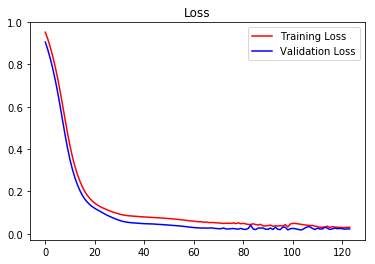

In [48]:
def plot_loss(list1, label1, list2=None, label2=None, title='Plot'):
    plt.figure()
    plt.title(title)
    plt.plot(list1, 'r', label=label1)
    if list2 is not None and list2 is not []:
        plt.plot(list2, 'b', label=label2)
    plt.legend()
    plt.savefig(f'{fig_dir}/loss.png')

plot_loss(history.history['loss'], 'Training Loss', history.history['val_loss'], 'Validation Loss', 'Loss')    

## Results

- with model: `gan-32_32-201802181741-epoch_104-val_loss_0.02.h5`
```
For transphorm: prediction_error = 0.008630567763397894, ideal_error = 0.02668760720465228, model_error = 0.012092632578226972
For gansystems: prediction_error = 0.020634671257184982, ideal_error = 0.05913845983435681, model_error = 4.989418096389726e-06
For panasonic: prediction_error = 0.02625170960829904, ideal_error = nan, model_error = 0.01130775244437753
```

- with model: `gan-201802172204-epoch_298-val_loss_0.02.h5` (had `[64] GRU nodes`)
```
For transphorm: prediction_error = 0.018219443779639112, ideal_error = 0.02668760720465228, model_error = 0.012092632578226972
For gansystems: prediction_error = 0.022094997912845405, ideal_error = 0.05913845983435681, model_error = 4.989418096389726e-06
For panasonic: prediction_error = 0.019040101893601502, ideal_error = nan, model_error = 0.01130775244437753
```

- with model: `gan-32_32-201802172236-epoch_130-val_loss_0.02.h5` (had `[32, 32] LSTM nodes`)
```
For transphorm: prediction_error = 0.01055438163755651, ideal_error = 0.02668760720465228, model_error = 0.012092632578226972
For gansystems: prediction_error = 0.015530452864580928, ideal_error = 0.05913845983435681, model_error = 4.989418096389726e-06
For panasonic: prediction_error = 0.029289353524128075, ideal_error = nan, model_error = 0.01130775244437753
```

In [49]:
def plot_prediction(x, y, y_pred, title=None, save=False):
    x = (x * x_std) + x_mean
    y = (y * y_std) + y_mean
    y_pred = (y_pred * y_std) + y_mean  # c2
    plot_data(c1=x[:,0], c2=y.ravel(), c3=x[:,1], c1_pred=None, c2_pred=y_pred.ravel(), c3_pred=None, title=title, save=save)

### Plotting prediction on test data (`expt`)

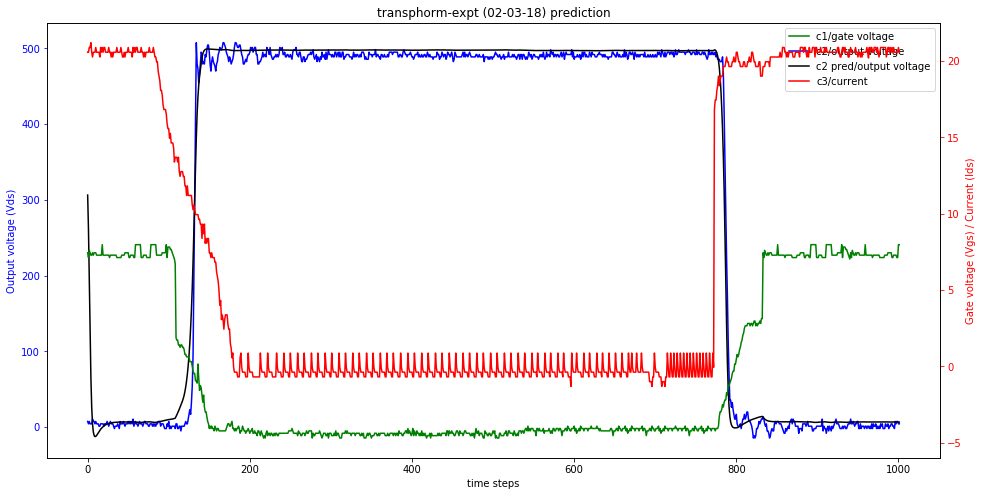

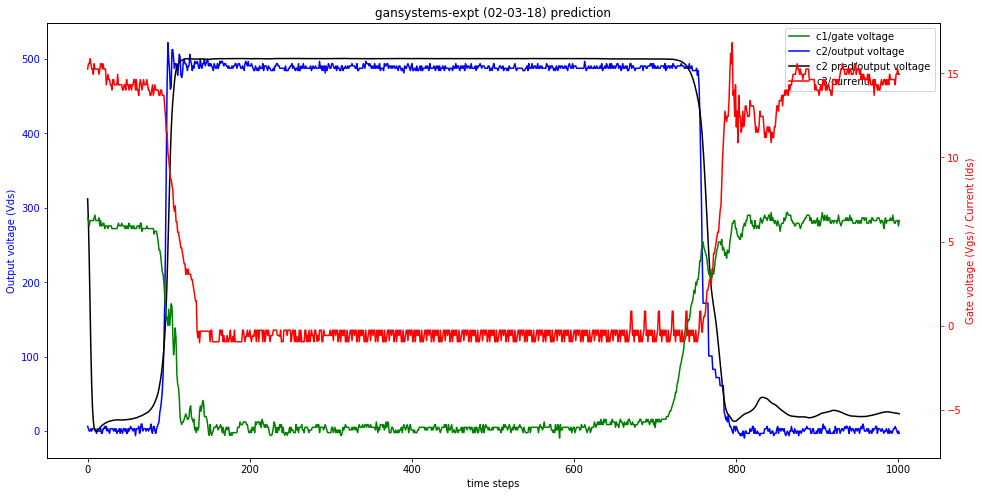

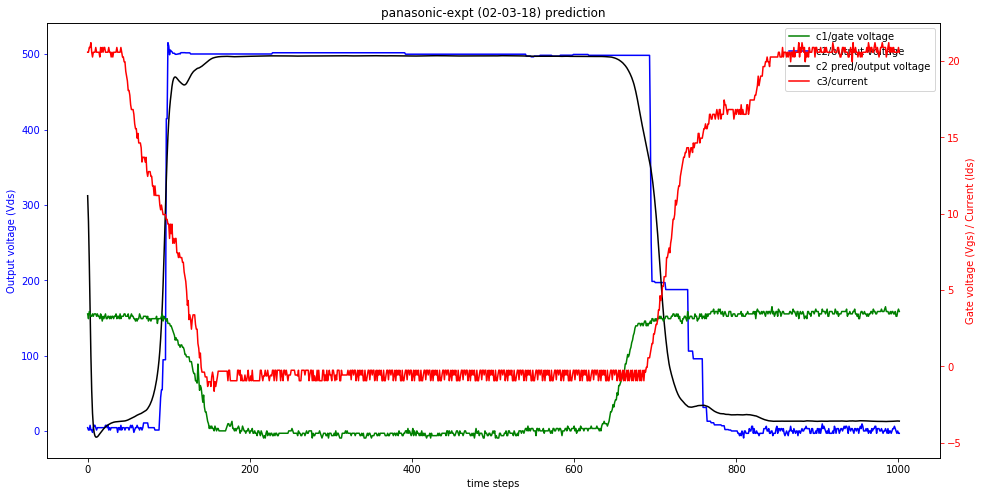

In [50]:
for i in range(x_test.shape[0]):
    row = test_df.iloc[i]
    figname = f'{row.device_name}-{row.graph_type} ({row.date}) prediction'
    plot_prediction(x_test[i], y_test[i], y_test_pred[i], title=figname, save=True)